# Statistical foundations of machine learning (INFO-F422)

A project by Daan Vandenberge (000577772) and Karolien Heymans (000577754).

For this project, multiple models were created to predict the damage on buildings after an earthquake. A large training dataset was constructed after the earthquake with multiple features for each house, together with a value for its total damage. The goal is to predict for a given test set which houses will be damaged the most. This information could then be usefull in the future to asses and prevent damage.

In [5]:
library(dplyr)
library(tidyr)
library(caret)
library(ggplot2)
library(GGally)
library(corrplot)
library(rpart)
library(nnet)
library(devtools)
library(RSNNS)

Loading required package: Rcpp


Attaching package: 'RSNNS'


The following objects are masked from 'package:caret':

    confusionMatrix, train




In [6]:
# Load the data
# row.names = 1: to use the first column of the dataset as the index
training_values = read.csv('train_values.csv', header = TRUE, row.names = 1)
training_labels = read.csv('train_labels.csv', header = TRUE, row.names = 1)
test_values = read.csv('test_values.csv',header = TRUE, row.names = 1)
test_labels = read.csv('submission_format.csv',header = TRUE, row.names = 1)

## 1. Data exploration and preprocessing
### 1.1. Content of the datasets

Since this project makes use of a large dataset that contains many features, it is important to do an initial explortation of the data before anything else. The following data was provided:
* The training_values dataset contains the features that will be used to train the model in which each building can by identified by its unique building_id. The building_id us used as an index.
* The training_labels dataset contains for every building_id its corresponding label which indicates the level of damage that was caused to the building due to the earthquake.

Our goals is to create a model that can predict the level of damage to buildings. To test the mode, the test_values dataset will be used for which no labels are given.

In [7]:
# The dimensions of the datasets
dim(training_values)
dim(training_labels)

[1] 260601     38

[1] 260601      1

By printing the dimensions of the datasets, the number of features and buildings can be determined. The training values contain 38 features and the training values and labels contain data for 260600 buildings.

In [5]:
# The column names are extracted to identify the 38 features.
features = names(training_values)
print(features)

 [1] "geo_level_1_id"                        
 [2] "geo_level_2_id"                        
 [3] "geo_level_3_id"                        
 [4] "count_floors_pre_eq"                   
 [5] "age"                                   
 [6] "area_percentage"                       
 [7] "height_percentage"                     
 [8] "land_surface_condition"                
 [9] "foundation_type"                       
[10] "roof_type"                             
[11] "ground_floor_type"                     
[12] "other_floor_type"                      
[13] "position"                              
[14] "plan_configuration"                    
[15] "has_superstructure_adobe_mud"          
[16] "has_superstructure_mud_mortar_stone"   
[17] "has_superstructure_stone_flag"         
[18] "has_superstructure_cement_mortar_stone"
[19] "has_superstructure_mud_mortar_brick"   
[20] "has_superstructure_cement_mortar_brick"
[21] "has_superstructure_timber"             
[22] "has_superstructure_bamboo"  

### 1.2. Histogram plot of the training labels

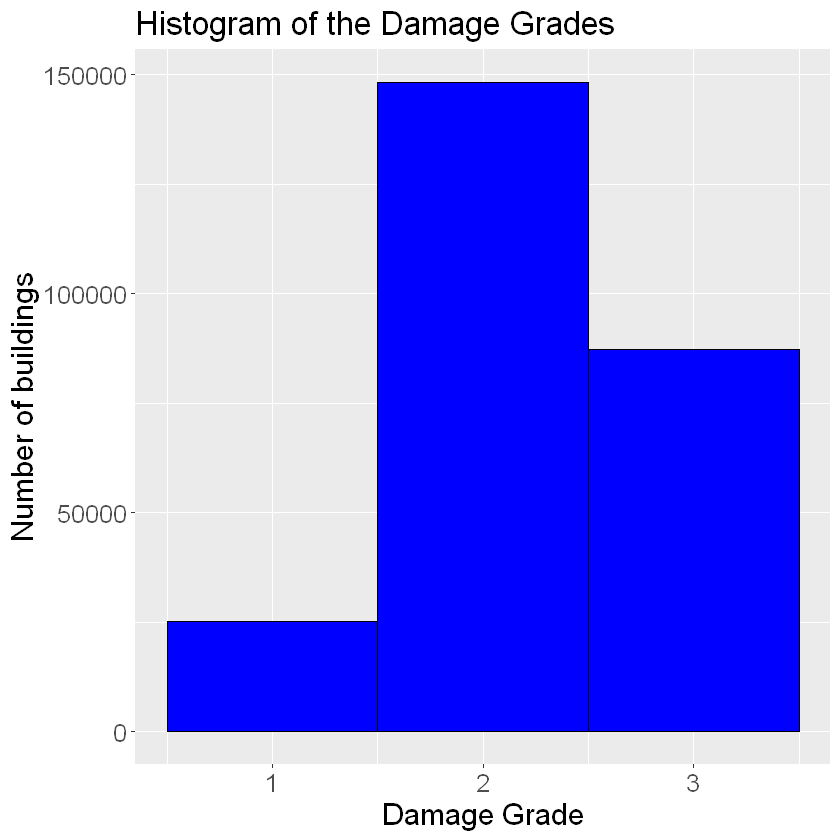

In [6]:
ggplot(training_labels, aes(x = damage_grade)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Histogram of the Damage Grades",
       x = "Damage Grade",
       y = "Number of buildings") +
  theme(axis.text = element_text(size = 15),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 20))

This histogram shows that the highest number of the buildings in the dataset have a damage grade of 2, and a much smaller number of buildings have a damage grade of 1. The number of building with a damage grade of 3 lies somewhere in between. The data of training labels is thus unbalanced. 

THIS UNBALANCE MAY LEAD TO BIASED RESULTS IN THE TRAINING PROCESS SO CHECK WPO FOR SOLUTION --> IK DENK IETS MET WEIGHTS

### 1.3. Structure of the datasets

In [27]:
# Check the presence of missing values.
summary(training_values)

 geo_level_1_id geo_level_2_id   geo_level_3_id  count_floors_pre_eq
 Min.   : 0.0   Min.   :   0.0   Min.   :    0   Min.   :1.00       
 1st Qu.: 7.0   1st Qu.: 350.0   1st Qu.: 3073   1st Qu.:2.00       
 Median :12.0   Median : 702.0   Median : 6270   Median :2.00       
 Mean   :13.9   Mean   : 701.1   Mean   : 6258   Mean   :2.13       
 3rd Qu.:21.0   3rd Qu.:1050.0   3rd Qu.: 9412   3rd Qu.:2.00       
 Max.   :30.0   Max.   :1427.0   Max.   :12567   Max.   :9.00       
      age         area_percentage   height_percentage land_surface_condition
 Min.   :  0.00   Min.   :  1.000   Min.   : 2.000    Length:260601         
 1st Qu.: 10.00   1st Qu.:  5.000   1st Qu.: 4.000    Class :character      
 Median : 15.00   Median :  7.000   Median : 5.000    Mode  :character      
 Mean   : 26.54   Mean   :  8.018   Mean   : 5.434                          
 3rd Qu.: 30.00   3rd Qu.:  9.000   3rd Qu.: 6.000                          
 Max.   :995.00   Max.   :100.000   Max.   :32.000     

In [28]:
head(training_values)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0
333020,8,558,6089,2,10,9,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0


In [29]:
# Check the presence of missing values.
summary(training_labels)

  damage_grade  
 Min.   :1.000  
 1st Qu.:2.000  
 Median :2.000  
 Mean   :2.238  
 3rd Qu.:3.000  
 Max.   :3.000  

In [30]:
head(training_labels)

,damage_grade
,<int>
802906,3
28830,2
94947,3
590882,2
201944,3
333020,2


### 1.4. Preprocessing of the data

The *summary()* function creates a summary of the variables present in the dataset. It is a useful function to check which variables are categorical and which are numerical. Additionally, it can also be used to check if the variables contain any NA values. In that case, those values would have to be replaces with mean values of the variables because machine learning algorithms can't handle missing data. In this case, there are no NA values in any of the datasets.

In [7]:
# Double check if there are missing values.
sum(is.na(training_values))
sum(is.na(training_labels))

[1] 0

[1] 0

Since it is not possible to use categorical features in machine learning algorithms, one-hot encoding was applied to transform that data into numerical values. One-hot encoding converts categorical values into a binary vector in which the presence of absence of that value is indicated. This will thus create additional features for each category.

In [8]:
sapply(training_values, class)

geo_level_1_id                         geo_level_2_id 
                             "integer"                              "integer" 
                        geo_level_3_id                    count_floors_pre_eq 
                             "integer"                              "integer" 
                                   age                        area_percentage 
                             "integer"                              "integer" 
                     height_percentage                 land_surface_condition 
                             "integer"                            "character" 
                       foundation_type                              roof_type 
                           "character"                            "character" 
                     ground_floor_type                       other_floor_type 
                           "character"                            "character" 
                              position                     plan_configuration 
                           "character"                            "character" 
          has_superstructure_adobe_mud    has_superstructure_mud_mortar_stone 
                             "integer"                              "integer" 
         has_superstructure_stone_flag has_superstructure_cement_mortar_stone 
                             "integer"                              "integer" 
   has_superstructure_mud_mortar_brick has_superstructure_cement_mortar_brick 
                             "integer"                              "integer" 
             has_superstructure_timber              has_superstructure_bamboo 
                             "integer"                              "integer" 
  has_superstructure_rc_non_engineered       has_superstructure_rc_engineered 
                             "integer"                              "integer" 
              has_superstructure_other                 legal_ownership_status 
                             "integer"                            "character" 
                        count_families                      has_secondary_use 
                             "integer"                              "integer" 
         has_secondary_use_agriculture                has_secondary_use_hotel 
                             "integer"                              "integer" 
              has_secondary_use_rental          has_secondary_use_institution 
                             "integer"                              "integer" 
              has_secondary_use_school             has_secondary_use_industry 
                             "integer"                              "integer" 
         has_secondary_use_health_post           has_secondary_use_gov_office 
                             "integer"                              "integer" 
          has_secondary_use_use_police                has_secondary_use_other 
                             "integer"                              "integer"

The *sapply()* function is used here to apply the *class()* function to each column of the training_values dataset which thus returns the classes for each feature. The class 'integer' means that the values of feature are integers and the vlass 'character' means that the values of the feature are characters. Since categories can also be integers, the features of class 'integer' were first analyzed via the summaries made earlier. This way, we found out that these features were either numerical or already binary. We can thus simply identify the categorical features as their class is 'character'. 

In [8]:
# This function print the categorical features
print(names(which(sapply(training_values, is.character))))

[1] "land_surface_condition" "foundation_type"        "roof_type"             
[4] "ground_floor_type"      "other_floor_type"       "position"              
[7] "plan_configuration"     "legal_ownership_status"


Now that the categorical variables are identified in the dataset, one-hot encoding can be performed.

In [9]:
# Perform one-hot encoding on the categorical features.
dummy <- dummyVars(" ~ .", data=training_values)
num_training_values = data.frame(predict(dummy, newdata=training_values))

# Check if the one-hot encoding of the numerical variables was succesful.
num_features = names(num_training_values)
print(num_features)

 [1] "geo_level_1_id"                        
 [2] "geo_level_2_id"                        
 [3] "geo_level_3_id"                        
 [4] "count_floors_pre_eq"                   
 [5] "age"                                   
 [6] "area_percentage"                       
 [7] "height_percentage"                     
 [8] "land_surface_conditionn"               
 [9] "land_surface_conditiono"               
[10] "land_surface_conditiont"               
[11] "foundation_typeh"                      
[12] "foundation_typei"                      
[13] "foundation_typer"                      
[14] "foundation_typeu"                      
[15] "foundation_typew"                      
[16] "roof_typen"                            
[17] "roof_typeq"                            
[18] "roof_typex"                            
[19] "ground_floor_typef"                    
[20] "ground_floor_typem"                    
[21] "ground_floor_typev"                    
[22] "ground_floor_typex"         

In [10]:
dim(num_training_values)

[1] 260601     68

The new dataset called num_training_values contains the numerical features and the categorical features that have been one-hot encoded. The dimensions of this new dataset shows that the number of features has increased to 67. This dataset can now be used in machine learning algorithms.

Furthermore, since numerical features use different scales and ranges, it is generally recommended to normalize them to make training much more stable. Since, it's not necessary to normalize binary features, the non-binary features were first isolated from the dataset.

In [11]:
# Identify the non-binary numerical variables.
non_binary_features = sapply(num_training_values, function(x) length(unique(x)) > 2)
binary_features = sapply(num_training_values, function(x) length(unique(x)) <= 2)
                             
names(num_training_values[, non_binary_features]) 

[1] "geo_level_1_id"      "geo_level_2_id"      "geo_level_3_id"     
[4] "count_floors_pre_eq" "age"                 "area_percentage"    
[7] "height_percentage"   "count_families"

There are thus 8 non-binary numerical features that should be normalized.

In [12]:
# Create a subset of the non-binary values and binary values.
non_binary_values = num_training_values[, non_binary_features]
binary_values = num_training_values[, binary_features]


# Normalize the non-binary features.
preProcValues = preProcess(non_binary_values, method=c("center", "scale"))
normalized_num_values = predict(preProcValues, non_binary_values)

# Merge the normalized numerical features with the binary features
normalized_training_values = cbind(normalized_num_values, binary_values)

The new dataset calles normalized_training_values contains the normalized non-binary numerical features and the categorical features that were converted into binary features.

### 1.5. Scatterplots between the numerical training values

In [13]:
combined_data = cbind(normalized_training_values,training_labels)


In [14]:
combined_data$damage_grade = as.factor(combined_data$damage_grade)

Correlated features in the dataset could lead to a problem known as **multicollinearity** which can have a negative effect on the accuracy of the predictive model. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


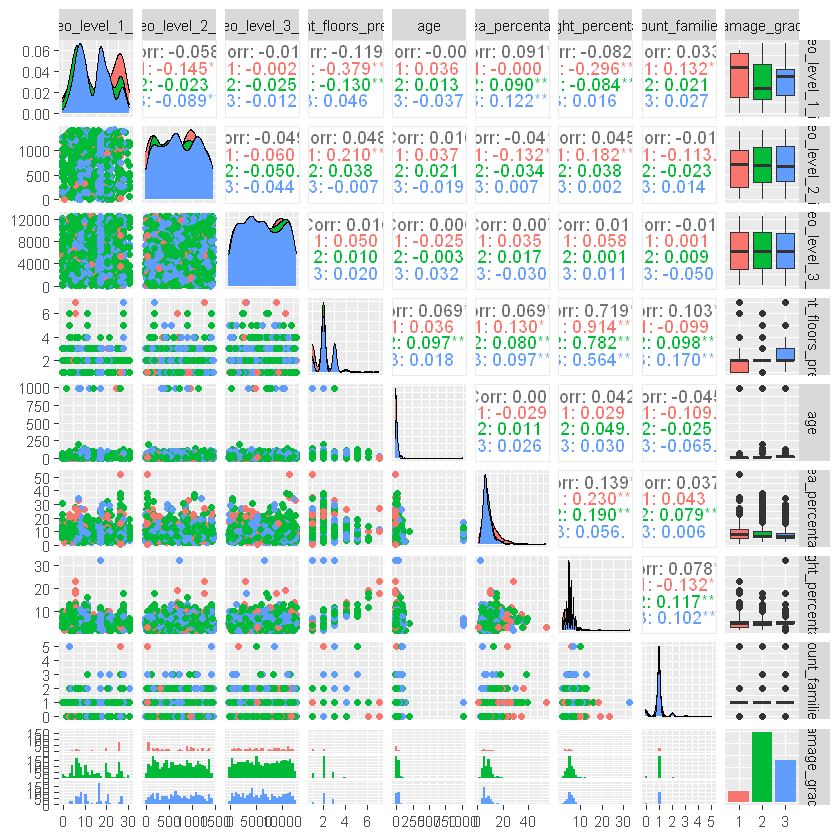

In [52]:
ggpairs(sampled_data, aes(colour = damage_grade))

In [15]:
correlation_matrix = cor(normalized_training_values)

In [16]:
# Set the correlation threshold
correlation_threshold <- 0.7

# Identify highly correlated featured. 
high_corr <- which(abs(correlation_matrix) > correlation_threshold & correlation_matrix != 1, arr.ind = TRUE)

# Print which features are highly correlated.
if (length(high_corr) == 0) {
  cat("No high correlation among variables.\n")
} else {
  cat("The following variables have high correlation:\n")
  for (i in 1:nrow(high_corr)) {
    var1 <- rownames(correlation_matrix)[high_corr[i, 1]]
    var2 <- colnames(correlation_matrix)[high_corr[i, 2]]
    cat(sprintf("%s and %s\n", var1, var2))
  }
}

The following variables have high correlation:
height_percentage and count_floors_pre_eq
count_floors_pre_eq and height_percentage
land_surface_conditiont and land_surface_conditionn
land_surface_conditionn and land_surface_conditiont
roof_typex and foundation_typei
roof_typeq and roof_typen
roof_typen and roof_typeq
foundation_typei and roof_typex
other_floor_types and roof_typex
roof_typex and other_floor_types
positiont and positions
positions and positiont
plan_configurationq and plan_configurationd
plan_configurationd and plan_configurationq
legal_ownership_statusv and legal_ownership_statusa
legal_ownership_statusa and legal_ownership_statusv
has_secondary_use_agriculture and has_secondary_use
has_secondary_use and has_secondary_use_agriculture


Here we can see that a lot of variables are correlated. This indicates that a linear model will not bee usefull since it will be strongly influenced by these correlations

## 2. Feature selection?

Next, feature selection is done to improve the accuracy of the predictive model. The feature selection sep aims at reducing the number of variables. This step has 2 main advantages:

* A decrease of the training time.
* A decrease of the complexity of the predictive model.

*Feature selection can be done in two main ways: Either via a filter method or a wrapper method. Filter methods evaluate the important of features without taking the performance of the learning algorithm into account. Unlike filter methods, wrapper methods do evaluate the performance of the learning algorithm for subsets of features. These mthods thus find a good subset of features using the learning algorithm itself. Since the goals is to create a predictor that is as accurate as possible, a wrapper method for the feature selection was done. *

First we split the dataframe back into the features and the labels. We also define the number of examples and the number of variables available in the dataset.

In [17]:
X<-combined_data[,setdiff(colnames(combined_data),"damage_grade")]
Y<-combined_data[,"damage_grade"]

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

Next, we perform a feature selection. The method chosen is the mRMR. This is a preprocessing method that attempts to asses the merits of features from the data, ignoring the effects of the selected feature subset on the performance of the learning algorithm. It does so by calculating the minimum redundancy maximum relevance

mRMR ranks the features from most relevant to the damage grade variable and the least redundancy to least relevant to the damage grade variable. Therefore, the relevant features can be selected starting from the top of the list. 

In [18]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
Y <- as.numeric(Y)

correlation <- abs(cor(X,Y))

# Initialization : No variables are selected and all the variables are candidates
selected <- c()
candidates <- 1:n

# mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redundant variables
mRMR_scores <- numeric(n)
for (j in 1:n) {
    redundancy_score <- numeric(length(candidates))
    
    if (length(selected) > 0) {
        # Compute the correlation between the selected variables and the candidates on the training set
        cor_selected_candidates <- cor(X[,selected,drop=F],X[,candidates,drop=F])
        # Compute the mean correlation for each candidate variable, across the selected variables
        redundancy_score <- apply(cor_selected_candidates,2,mean)
    }
    
    # mRMR: minimum Redundancy Maximum Relevancy
    mRMR_score <- correlation[candidates] - redundancy_score
    mRMR_scores[candidates] <- mRMR_score
    
    # Select the candidate variable that maximizes the mRMR score
    selected_current <- candidates[which.max(mRMR_score)]
    selected <- c(selected,selected_current)
    
    # Remove the selected variables from the candidates
    candidates <- setdiff(candidates,selected_current)
}

ranking <- selected
mRMR_ranking <- paste(ranking, collapse = ", ")
mRMR_scores <- mRMR_scores[ranking]

The selection of the relevant features was based on the mRMR scores and the research question. First of all, a threshold of 0.1 was initially considered as a possible cut-off. Features before this cut-off were mostly related to the state of the building whereas those after the cut-off were more related to the building's usage. However, since the feature that comes right after the cut-off is also related to the building's structure, it was included as well.

The reason behind selecting the features that are related to the building's structure is that they are most relevant to the research question. For instance, a building that is build with weak materials may suffer greater damage due to an earthquake than one that is build with very firm materials.

In [19]:
mRMR_ranking <- unlist(strsplit(mRMR_ranking,", "))
table <- data.frame(Rank = mRMR_ranking, Score = mRMR_scores)

table

Rank,Score
<chr>,<dbl>
14,0.34335543
22,0.83301994
16,0.46892034
44,0.35811874
19,0.36056568
20,0.30085457
48,0.31125832
13,0.22653311
26,0.21439971


In [22]:
ranked_features <- c(14, 22, 16, 44, 19, 20, 48, 13, 26, 15, 25, 4, 27, 17, 18, 52, 51, 28, 49, 54, 56, 6, 43, 45, 60, 61, 31, 32, 1, 35, 42, 2, 8, 50, 46, 57, 58, 5, 23, 53, 40, 33, 34, 62, 29, 24, 21, 12, 10, 11, 9, 7, 39, 41, 68, 3, 55, 64, 63, 65, 66, 37, 47, 59, 38, 36, 67, 30)
colnames(normalized_training_values[,relevant_features])

[1] "foundation_typer"                      
 [2] "ground_floor_typev"                    
 [3] "foundation_typew"                      
 [4] "has_superstructure_mud_mortar_stone"   
 [5] "roof_typex"                            
 [6] "ground_floor_typef"                    
 [7] "has_superstructure_cement_mortar_brick"
 [8] "foundation_typei"                      
 [9] "other_floor_typeq"                     
[10] "foundation_typeu"                      
[11] "other_floor_typej"                     
[12] "count_floors_pre_eq"                   
[13] "other_floor_types"                     
[14] "roof_typen"                            
[15] "roof_typeq"                            
[16] "has_superstructure_rc_engineered"      
[17] "has_superstructure_rc_non_engineered"  
[18] "other_floor_typex"                     
[19] "has_superstructure_timber"

In [21]:
relevant_features <- c(14, 22, 16, 44, 19, 20, 48, 13, 26, 15, 25, 4, 27, 17, 18, 52, 51, 28,49)
colnames(normalized_training_values[,relevant_features])

[1] "foundation_typer"                      
 [2] "ground_floor_typev"                    
 [3] "foundation_typew"                      
 [4] "has_superstructure_mud_mortar_stone"   
 [5] "roof_typex"                            
 [6] "ground_floor_typef"                    
 [7] "has_superstructure_cement_mortar_brick"
 [8] "foundation_typei"                      
 [9] "other_floor_typeq"                     
[10] "foundation_typeu"                      
[11] "other_floor_typej"                     
[12] "count_floors_pre_eq"                   
[13] "other_floor_types"                     
[14] "roof_typen"                            
[15] "roof_typeq"                            
[16] "has_superstructure_rc_engineered"      
[17] "has_superstructure_rc_non_engineered"  
[18] "other_floor_typex"                     
[19] "has_superstructure_timber"

In [23]:
relevant_training_values <- normalized_training_values[, relevant_features]
head(relevant_training_values)

,foundation_typer,ground_floor_typev,foundation_typew,has_superstructure_mud_mortar_stone,roof_typex,ground_floor_typef,has_superstructure_cement_mortar_brick,foundation_typei,other_floor_typeq,foundation_typeu,other_floor_typej,count_floors_pre_eq,other_floor_types,roof_typen,roof_typeq,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,other_floor_typex,has_superstructure_timber
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
802906,1,0,0,1,0,1,0,0,1,0,0,-0.1782734,0,1,0,0,0,0,0
28830,1,0,0,1,0,0,0,0,1,0,0,-0.1782734,0,1,0,0,0,0,0
94947,1,0,0,1,0,1,0,0,0,0,0,-0.1782734,0,1,0,0,0,1,0
590882,1,0,0,1,0,1,0,0,0,0,0,-0.1782734,0,1,0,0,0,1,1
201944,1,0,0,0,0,1,0,0,0,0,0,1.1959862,0,1,0,0,0,1,0
333020,1,0,0,1,0,1,0,0,1,0,0,-0.1782734,0,1,0,0,0,0,0


# correlation with the output

The following code performs features selection by keeping the most correlated variables with the output


## 3. Learning methods

Preprocessing of the test values (the same way as the training_values).

In [24]:
sum(is.na(test_values))

[1] 0

next, one-hot encoding was performed and checked if it was succesful

In [25]:
# Perform one-hot encoding on the categorical features.
dummy <- dummyVars(" ~ .", data=test_values)
num_test_values = data.frame(predict(dummy, newdata=test_values))

# Check if the one-hot encoding of the numerical variables was succesful.
num_test_features = names(num_test_values)
print(num_test_features)

 [1] "geo_level_1_id"                        
 [2] "geo_level_2_id"                        
 [3] "geo_level_3_id"                        
 [4] "count_floors_pre_eq"                   
 [5] "age"                                   
 [6] "area_percentage"                       
 [7] "height_percentage"                     
 [8] "land_surface_conditionn"               
 [9] "land_surface_conditiono"               
[10] "land_surface_conditiont"               
[11] "foundation_typeh"                      
[12] "foundation_typei"                      
[13] "foundation_typer"                      
[14] "foundation_typeu"                      
[15] "foundation_typew"                      
[16] "roof_typen"                            
[17] "roof_typeq"                            
[18] "roof_typex"                            
[19] "ground_floor_typef"                    
[20] "ground_floor_typem"                    
[21] "ground_floor_typev"                    
[22] "ground_floor_typex"         

In [26]:
dim(num_test_values)

[1] 86868    68

In [27]:
non_binary_test_features = sapply(num_test_values, function(x) length(unique(x)) > 2)
binary_test_features = sapply(num_test_values, function(x) length(unique(x)) <= 2)

# Create a subset of the non-binary values and binary values.
non_binary_test_values = num_test_values[, non_binary_test_features]
binary_test_values = num_test_values[, binary_test_features]


# Normalize the non-binary features.
preProcValues = preProcess(non_binary_test_values, method=c("center", "scale"))
normalized_num_test_values = predict(preProcValues, non_binary_test_values)

# Merge the normalized numerical features with the binary features
normalized_test_values = cbind(normalized_num_test_values, binary_test_values)


# Save the normalized data set to a CSV file
write.csv(normalized_test_values, "normalized_test_values.csv", row.names = FALSE)

### 3.1. Decision tree

A decision tree is a commonly used method for making predictions. It is a form of classification tree, which is a model that performs a classification of the target variable, in this case, the damage grade of a building. Such tree structure contains internal nodes associated to a specific feature, and terminal nodes that are associated to a specific damage grade. Classification is then performed starting from the root node by transversing through the internal nodes of the decision tree based on the values of the associated feature. When a terminal node is reached, the damage grade associated to that terminal node is assigned to the particular building ID. Since the damage grade has three possible levels 1, 2, and 3, our classification task will be to discriminate between three classes. 

In [12]:
# To define the training values.
X = combined_data[,setdiff(colnames(combined_data),"damage_grade")]
# To define the training labels.
Y = combined_data[,"damage_grade"]

# Number of buildings.
N = nrow(X)
# Number of features.
n = ncol(X)    

In [28]:
combined_data$damage_grade = as.factor(combined_data$damage_grade)

In [38]:
class(combined_data$damage_grade)

[1] "factor"

In [32]:
decision_tree_model <- rpart(damage_grade ~ ., method="class",data=combined_data)

In [50]:
predicted_labels = predict(decision_tree_model, newdata = normalized_test_values, type = "class")
round_predicted_labels = as.factor(round(predicted_labels))

ERROR: Error in eval(expr, envir, enclos): object 'decision_tree_model' not found


In [53]:
test_labels$damage_grade = round_predicted_labels

In [54]:
head(test_labels)

,damage_grade
,<fct>
300051,3
99355,2
890251,2
745817,2
421793,3
871976,2


In [56]:
write.csv(test_labels, "decision_tree_test_labels.csv")

In the code below, training of the decision tree model was performed implemented with cross-validation to assess the performance of the model. The cross-validation is performed by dividing the dataset into a number of fold (or subsets). The idea is then to train and test the model on di

In [30]:
# Number of folds for the cross-validation.
CV_folds <- 10

# Calculate the size of each fold as the floor division of the number of rows in 
# the combined data set by the number of folds.
size_CV <- floor(nrow(combined_data) / CV_folds)

# To store the cross-validation error of each fold.
CV_err <- numeric(CV_folds)

# To loop over each fold.
for (i in 1:CV_folds) {
  
  # For each fold, a test set is defined.
  idx_ts <- (((i - 1) * size_CV + 1):(i * size_CV))
  X_ts <- X[idx_ts, ]
  Y_ts <- Y[idx_ts]
  
  # For each loop, a training set is defined.
  idx_tr <- setdiff(1:nrow(combined_data), idx_ts)
  X_tr <- X[idx_tr, ]
  Y_tr <- Y[idx_tr]
  
  # Fit a decision tree model on the training set.
  DS <- cbind(X_tr, target_variable = Y_tr)
  model <- rpart(target_variable ~ ., data = DS)
  
  # The damage grades for the test set are predicted.
  Y_hat_ts <- predict(model, X_ts)
  
  # The MSE between the predicted and actual damage grade is computed (CV error)
  CV_err[i] <- mean((Y_hat_ts - Y_ts)^2)
}

# Print the cross-validation error
cat("CV error:", mean(CV_err))

CV error: 0.2722437

### 3.2 Neural network

Neural networks is a model in machine learning that mimics the way the human brain works and processes data. The input from the data is given as an input to the model as a set of numbers, which are the features from the dataset. Next the data is processed by the first layer of the neural network. Each neuron receives only a part of the complete dataset and uses it for a simple calculation. The output of this layer is then passed to one or multiple neurons of the next layer. The amount of layers available in the model depends on the task at hand and its complexity. The final layer of neurons decide what the output of the model will be. To train this model, it is given a dataset with labels so the model itself can adjust the weights between the neurons, which will then minimize the error between the predicted and the true output. This is a process where the chain rule to compute the error with respect to each neuron. The weights are then updated with an optimization algorithm. 
The reason why we chose to use neural networks is because this model is well suited to use large quantities of data to create a network. Normally Neural networks can struggle when tha data set is incomplete. Since our dataset did not contain any NA value, we decided to use neural network.

In [1]:
install.packages("nnet")

Installing package into 'C:/Users/cobot/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'nnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cobot\AppData\Local\Temp\Rtmpg9vJXL\downloaded_packages


In [2]:
install.packages("devtools")

Installing package into 'C:/Users/cobot/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

also installing the dependencies 'askpass', 'credentials', 'openssl', 'sys', 'zip', 'gitcreds', 'httr2', 'ini', 'httpuv', 'mime', 'xtable', 'fontawesome', 'sourcetools', 'later', 'promises', 'sass', 'jquerylib', 'systemfonts', 'textshaping', 'tinytex', 'xfun', 'highr', 'diffobj', 'rematch2', 'clipr', 'curl', 'gert', 'gh', 'rappdirs', 'rprojroot', 'rstudioapi', 'whisker', 'yaml', 'cachem', 'shiny', 'callr', 'processx', 'bslib', 'downlit', 'httr', 'ragg', 'rmarkdown', 'xml2', 'htmlwidgets', 'xopen', 'brew', 'commonmark', 'knitr', 'brio', 'praise', 'ps', 'waldo', 'usethis', 'desc', 'fs', 'memoise', 'miniUI', 'pkgbuild', 'pkgdown', 'pkgload', 'profvis', 'rcmdcheck', 'remotes', 'roxygen2', 'rversions', 'sessioninfo', 'testthat', 'urlchecker'





  There are binary versions available but the source versions are later:
       binary source needs_compilation
httpuv  1.6.9 1.6.10              TRUE
httr    1.4.5  1.4.6             FALSE

  Binaries will be installed
package 'askpass' successfully unpacked and MD5 sums checked
package 'credentials' successfully unpacked and MD5 sums checked
package 'openssl' successfully unpacked and MD5 sums checked
package 'sys' successfully unpacked and MD5 sums checked
package 'zip' successfully unpacked and MD5 sums checked
package 'gitcreds' successfully unpacked and MD5 sums checked
package 'httr2' successfully unpacked and MD5 sums checked
package 'ini' successfully unpacked and MD5 sums checked
package 'httpuv' successfully unpacked and MD5 sums checked
package 'mime' successfully unpacked and MD5 sums checked
package 'xtable' successfully unpacked and MD5 sums checked
package 'fontawesome' successfully unpacked and MD5 sums checked
package 'sourcetools' successfully unpacked and MD5 sums 

installing the source package 'httr'




In [3]:
install.packages("RSNNS")

Installing package into 'C:/Users/cobot/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'RSNNS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cobot\AppData\Local\Temp\Rtmpg9vJXL\downloaded_packages


In [32]:
combined_relevant_features = cbind(relevant_training_values,training_labels)

In [42]:
head(combined_relevant_features)

,foundation_typer,ground_floor_typev,foundation_typew,has_superstructure_mud_mortar_stone,roof_typex,ground_floor_typef,has_superstructure_cement_mortar_brick,foundation_typei,other_floor_typeq,foundation_typeu,other_floor_typej,count_floors_pre_eq,other_floor_types,roof_typen,roof_typeq,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,other_floor_typex,has_superstructure_timber,damage_grade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
802906,1,0,0,1,0,1,0,0,1,0,0,-0.1782734,0,1,0,0,0,0,0,3
28830,1,0,0,1,0,0,0,0,1,0,0,-0.1782734,0,1,0,0,0,0,0,2
94947,1,0,0,1,0,1,0,0,0,0,0,-0.1782734,0,1,0,0,0,1,0,3
590882,1,0,0,1,0,1,0,0,0,0,0,-0.1782734,0,1,0,0,0,1,1,2
201944,1,0,0,0,0,1,0,0,0,0,0,1.1959862,0,1,0,0,0,1,0,3
333020,1,0,0,1,0,1,0,0,1,0,0,-0.1782734,0,1,0,0,0,0,0,2


In [43]:
dim(combined_relevant_features)

[1] 260601     20

In [44]:
hidden_nodes = 5
NN_out = nnet(damage_grade ~ ., method="class",data=combined_relevant_features, size = hidden_nodes, skip = FALSE, trace = T, maxit = 3000, rang = 0.2)

# weights:  106
initial  value 893202.459948 
final  value 497131.000000 
converged


In [45]:
NN_out

a 19-5-1 network with 106 weights
inputs: foundation_typer ground_floor_typev foundation_typew has_superstructure_mud_mortar_stone roof_typex ground_floor_typef has_superstructure_cement_mortar_brick foundation_typei other_floor_typeq foundation_typeu other_floor_typej count_floors_pre_eq other_floor_types roof_typen roof_typeq has_superstructure_rc_engineered has_superstructure_rc_non_engineered other_floor_typex has_superstructure_timber 
output(s): damage_grade 
options were -

Subset of normalized test values with only the relevant features.

In [46]:
relevant_test_values = normalized_test_values[,relevant_features]

In [47]:
Predicted_labels_NN = predict(NN_out, newdata = relevant_test_values)

In [48]:
head(Predicted_labels_NN)

300051,1
99355,1
890251,1
745817,1
421793,1
871976,1


In [41]:
write.csv(Predicted_labels_NN, "NN_test_labels.csv")

hidden nodes selection

In [ ]:
# To define the training values.
X = combined_data[,setdiff(colnames(combined_data),"damage_grade")]
# To define the training labels.
Y = combined_data[,"damage_grade"]

# Number of buildings.
N = nrow(X)
# Number of features.
n = ncol(X)    

In [ ]:
# Define the range of hidden nodes to test
hidden_nodes <- seq(from = 1, to = 10, by = 1)

# Number of folds for the cross-validation.
CV_folds <- 10

# Calculate the size of each fold as the floor division of the number of rows in 
# the combined data set by the number of folds.
size_CV <- floor(nrow(combined_data) / CV_folds)

# To store the cross-validation error of each fold.
CV_err <- numeric(CV_folds)

# To loop over each fold.
for (i in 1:CV_folds) {
  
  # For each fold, a test set is defined.
  idx_ts <- (((i - 1) * size_CV + 1):(i * size_CV))
  X_ts <- X[idx_ts, ]
  Y_ts <- Y[idx_ts]
  
  # For each loop, a training set is defined.
  idx_tr <- setdiff(1:nrow(combined_data), idx_ts)
  X_tr <- X[idx_tr, ]
  Y_tr <- Y[idx_tr]
  
  # Fit a decision tree model on the training set.
  DS <- cbind(X_tr, target_variable = Y_tr)
  model <- nnet(target_variable ~ ., data = DS, size = c(hidden_nodes[i]), linout = TRUE)
  
  # The damage grades for the test set are predicted.
  Y_hat_ts <- predict(model, X_ts)
  
  # The MSE between the predicted and actual damage grade is computed (CV error)
  CV_err[i] <- mean((Y_hat_ts - Y_ts)^2)
}

df <- data.frame(hidden_nodes = hidden_nodes, error = CV_err)
ggplot(df, aes(x = hidden_nodes, y = error)) +
  geom_line() +
  geom_point() +
  labs(x = "Number of hidden nodes", y = "Training error")